In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from gplearn.genetic import SymbolicRegressor

from numba import jit, float64, int64

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

tf.keras.backend.clear_session()

In [2]:
@jit(nopython=True)
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [3]:
data_df = pd.read_csv('../../_00_data/Kr2010_prep.csv', index_col=0)

min_rt = data_df.groupby(by='sbj')['rt'].min()

tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(data_df[['rt', 'Right', 'sbj']])
X_train = np.asarray(data_df[['item_value_1', 'item_value_2', 'gaze_1', 'gaze_2']])

obs_test = np.asarray(data_df[['rt', 'Right', 'sbj']])
X_test = np.asarray(data_df[['item_value_1', 'item_value_2', 'gaze_1', 'gaze_2']])

print(X_train.shape, X_test.shape)

(3522, 4) (3522, 4)


In [4]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):

    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))

    ll1 = (1 - data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 0]))

    return -2*tf.reduce_sum(tf.math.log(tf.maximum(ll1 + ll2, 1e-14)), axis=-1)

In [5]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [6]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = data_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 129       
                                                                 
Total params: 422 (1.65 KB)
Trainable params: 422 (1.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [7]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [8]:
# batch_size = X_train.shape[0]
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, obs_train))
# train_dataset = train_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=4000)

Epoch 1/4000
1/1 [==============================] - 1s 583ms/step - loss: 21503.9531
Epoch 2/4000
1/1 [==============================] - 0s 3ms/step - loss: 21405.4883
Epoch 3/4000
1/1 [==============================] - 0s 2ms/step - loss: 21333.6074
Epoch 4/4000
1/1 [==============================] - 0s 2ms/step - loss: 21273.0273
Epoch 5/4000
1/1 [==============================] - 0s 2ms/step - loss: 21218.9883
Epoch 6/4000
1/1 [==============================] - 0s 4ms/step - loss: 21169.3047
Epoch 7/4000
1/1 [==============================] - 0s 3ms/step - loss: 21122.7754
Epoch 8/4000
1/1 [==============================] - 0s 2ms/step - loss: 21078.6309
Epoch 9/4000
1/1 [==============================] - 0s 4ms/step - loss: 21036.3672
Epoch 10/4000
1/1 [==============================] - 0s 3ms/step - loss: 20995.6328
Epoch 11/4000
1/1 [==============================] - 0s 2ms/step - loss: 20956.1797
Epoch 12/4000
1/1 [==============================] - 0s 3ms/step - loss: 20917.8145

1/1 [==============================] - 0s 3ms/step - loss: 18736.3477
Epoch 99/4000
1/1 [==============================] - 0s 3ms/step - loss: 18717.1426
Epoch 100/4000
1/1 [==============================] - 0s 2ms/step - loss: 18698.0547
Epoch 101/4000
1/1 [==============================] - 0s 2ms/step - loss: 18679.0918
Epoch 102/4000
1/1 [==============================] - 0s 2ms/step - loss: 18660.2480
Epoch 103/4000
1/1 [==============================] - 0s 3ms/step - loss: 18641.5273
Epoch 104/4000
1/1 [==============================] - 0s 8ms/step - loss: 18622.9277
Epoch 105/4000
1/1 [==============================] - 0s 2ms/step - loss: 18604.4434
Epoch 106/4000
1/1 [==============================] - 0s 3ms/step - loss: 18586.0781
Epoch 107/4000
1/1 [==============================] - 0s 3ms/step - loss: 18567.8281
Epoch 108/4000
1/1 [==============================] - 0s 2ms/step - loss: 18549.6914
Epoch 109/4000
1/1 [==============================] - 0s 2ms/step - loss: 18531.6

1/1 [==============================] - 0s 3ms/step - loss: 17315.1406
Epoch 195/4000
1/1 [==============================] - 0s 3ms/step - loss: 17303.6445
Epoch 196/4000
1/1 [==============================] - 0s 2ms/step - loss: 17292.1992
Epoch 197/4000
1/1 [==============================] - 0s 2ms/step - loss: 17280.8066
Epoch 198/4000
1/1 [==============================] - 0s 2ms/step - loss: 17269.4570
Epoch 199/4000
1/1 [==============================] - 0s 3ms/step - loss: 17258.1602
Epoch 200/4000
1/1 [==============================] - 0s 3ms/step - loss: 17246.9102
Epoch 201/4000
1/1 [==============================] - 0s 2ms/step - loss: 17235.7051
Epoch 202/4000
1/1 [==============================] - 0s 3ms/step - loss: 17224.5527
Epoch 203/4000
1/1 [==============================] - 0s 2ms/step - loss: 17213.4434
Epoch 204/4000
1/1 [==============================] - 0s 2ms/step - loss: 17202.3809
Epoch 205/4000
1/1 [==============================] - 0s 3ms/step - loss: 17191.

1/1 [==============================] - 0s 3ms/step - loss: 16389.7695
Epoch 291/4000
1/1 [==============================] - 0s 3ms/step - loss: 16381.6055
Epoch 292/4000
1/1 [==============================] - 0s 3ms/step - loss: 16373.4688
Epoch 293/4000
1/1 [==============================] - 0s 4ms/step - loss: 16365.3516
Epoch 294/4000
1/1 [==============================] - 0s 3ms/step - loss: 16357.2568
Epoch 295/4000
1/1 [==============================] - 0s 3ms/step - loss: 16349.1875
Epoch 296/4000
1/1 [==============================] - 0s 3ms/step - loss: 16341.1416
Epoch 297/4000
1/1 [==============================] - 0s 4ms/step - loss: 16333.1172
Epoch 298/4000
1/1 [==============================] - 0s 3ms/step - loss: 16325.1162
Epoch 299/4000
1/1 [==============================] - 0s 3ms/step - loss: 16317.1348
Epoch 300/4000
1/1 [==============================] - 0s 3ms/step - loss: 16309.1748
Epoch 301/4000
1/1 [==============================] - 0s 10ms/step - loss: 16301

1/1 [==============================] - 0s 3ms/step - loss: 15676.7607
Epoch 387/4000
1/1 [==============================] - 0s 3ms/step - loss: 15669.7744
Epoch 388/4000
1/1 [==============================] - 0s 3ms/step - loss: 15662.7881
Epoch 389/4000
1/1 [==============================] - 0s 4ms/step - loss: 15655.8047
Epoch 390/4000
1/1 [==============================] - 0s 3ms/step - loss: 15648.8223
Epoch 391/4000
1/1 [==============================] - 0s 3ms/step - loss: 15641.8398
Epoch 392/4000
1/1 [==============================] - 0s 3ms/step - loss: 15634.8584
Epoch 393/4000
1/1 [==============================] - 0s 4ms/step - loss: 15627.8789
Epoch 394/4000
1/1 [==============================] - 0s 3ms/step - loss: 15620.8965
Epoch 395/4000
1/1 [==============================] - 0s 2ms/step - loss: 15613.9121
Epoch 396/4000
1/1 [==============================] - 0s 3ms/step - loss: 15606.9326
Epoch 397/4000
1/1 [==============================] - 0s 3ms/step - loss: 15599.

1/1 [==============================] - 0s 8ms/step - loss: 14841.7783
Epoch 483/4000
1/1 [==============================] - 0s 3ms/step - loss: 14831.4922
Epoch 484/4000
1/1 [==============================] - 0s 3ms/step - loss: 14821.2812
Epoch 485/4000
1/1 [==============================] - 0s 3ms/step - loss: 14811.1357
Epoch 486/4000
1/1 [==============================] - 0s 3ms/step - loss: 14801.0586
Epoch 487/4000
1/1 [==============================] - 0s 2ms/step - loss: 14791.0469
Epoch 488/4000
1/1 [==============================] - 0s 3ms/step - loss: 14781.0957
Epoch 489/4000
1/1 [==============================] - 0s 2ms/step - loss: 14771.2012
Epoch 490/4000
1/1 [==============================] - 0s 3ms/step - loss: 14761.3682
Epoch 491/4000
1/1 [==============================] - 0s 2ms/step - loss: 14751.5830
Epoch 492/4000
1/1 [==============================] - 0s 2ms/step - loss: 14741.8467
Epoch 493/4000
1/1 [==============================] - 0s 3ms/step - loss: 14732.

1/1 [==============================] - 0s 2ms/step - loss: 13943.8584
Epoch 579/4000
1/1 [==============================] - 0s 3ms/step - loss: 13933.9365
Epoch 580/4000
1/1 [==============================] - 0s 2ms/step - loss: 13923.9648
Epoch 581/4000
1/1 [==============================] - 0s 2ms/step - loss: 13913.9482
Epoch 582/4000
1/1 [==============================] - 0s 2ms/step - loss: 13903.8867
Epoch 583/4000
1/1 [==============================] - 0s 3ms/step - loss: 13893.7773
Epoch 584/4000
1/1 [==============================] - 0s 3ms/step - loss: 13883.6211
Epoch 585/4000
1/1 [==============================] - 0s 2ms/step - loss: 13873.4131
Epoch 586/4000
1/1 [==============================] - 0s 3ms/step - loss: 13863.1621
Epoch 587/4000
1/1 [==============================] - 0s 2ms/step - loss: 13852.8613
Epoch 588/4000
1/1 [==============================] - 0s 2ms/step - loss: 13842.5107
Epoch 589/4000
1/1 [==============================] - 0s 3ms/step - loss: 13832.

1/1 [==============================] - 0s 3ms/step - loss: 12964.0020
Epoch 675/4000
1/1 [==============================] - 0s 2ms/step - loss: 12954.7822
Epoch 676/4000
1/1 [==============================] - 0s 3ms/step - loss: 12945.5771
Epoch 677/4000
1/1 [==============================] - 0s 3ms/step - loss: 12936.3721
Epoch 678/4000
1/1 [==============================] - 0s 2ms/step - loss: 12927.1836
Epoch 679/4000
1/1 [==============================] - 0s 2ms/step - loss: 12917.9971
Epoch 680/4000
1/1 [==============================] - 0s 2ms/step - loss: 12908.8252
Epoch 681/4000
1/1 [==============================] - 0s 3ms/step - loss: 12899.6543
Epoch 682/4000
1/1 [==============================] - 0s 2ms/step - loss: 12890.5010
Epoch 683/4000
1/1 [==============================] - 0s 2ms/step - loss: 12881.3496
Epoch 684/4000
1/1 [==============================] - 0s 2ms/step - loss: 12872.2139
Epoch 685/4000
1/1 [==============================] - 0s 2ms/step - loss: 12863.

1/1 [==============================] - 0s 3ms/step - loss: 12157.5791
Epoch 771/4000
1/1 [==============================] - 0s 2ms/step - loss: 12150.3203
Epoch 772/4000
1/1 [==============================] - 0s 2ms/step - loss: 12143.1162
Epoch 773/4000
1/1 [==============================] - 0s 3ms/step - loss: 12135.9082
Epoch 774/4000
1/1 [==============================] - 0s 2ms/step - loss: 12128.7568
Epoch 775/4000
1/1 [==============================] - 0s 2ms/step - loss: 12121.5986
Epoch 776/4000
1/1 [==============================] - 0s 2ms/step - loss: 12114.4990
Epoch 777/4000
1/1 [==============================] - 0s 2ms/step - loss: 12107.3936
Epoch 778/4000
1/1 [==============================] - 0s 3ms/step - loss: 12100.3428
Epoch 779/4000
1/1 [==============================] - 0s 3ms/step - loss: 12093.2891
Epoch 780/4000
1/1 [==============================] - 0s 2ms/step - loss: 12086.2881
Epoch 781/4000
1/1 [==============================] - 0s 2ms/step - loss: 12079.

1/1 [==============================] - 0s 3ms/step - loss: 11556.2285
Epoch 867/4000
1/1 [==============================] - 0s 3ms/step - loss: 11550.7568
Epoch 868/4000
1/1 [==============================] - 0s 2ms/step - loss: 11545.3330
Epoch 869/4000
1/1 [==============================] - 0s 2ms/step - loss: 11539.8896
Epoch 870/4000
1/1 [==============================] - 0s 2ms/step - loss: 11534.4961
Epoch 871/4000
1/1 [==============================] - 0s 3ms/step - loss: 11529.0820
Epoch 872/4000
1/1 [==============================] - 0s 3ms/step - loss: 11523.7148
Epoch 873/4000
1/1 [==============================] - 0s 2ms/step - loss: 11518.3281
Epoch 874/4000
1/1 [==============================] - 0s 2ms/step - loss: 11512.9922
Epoch 875/4000
1/1 [==============================] - 0s 3ms/step - loss: 11507.6377
Epoch 876/4000
1/1 [==============================] - 0s 4ms/step - loss: 11502.3291
Epoch 877/4000
1/1 [==============================] - 0s 3ms/step - loss: 11496.

1/1 [==============================] - 0s 2ms/step - loss: 11092.4414
Epoch 963/4000
1/1 [==============================] - 0s 2ms/step - loss: 11088.1436
Epoch 964/4000
1/1 [==============================] - 0s 2ms/step - loss: 11083.8896
Epoch 965/4000
1/1 [==============================] - 0s 2ms/step - loss: 11079.6055
Epoch 966/4000
1/1 [==============================] - 0s 3ms/step - loss: 11075.3740
Epoch 967/4000
1/1 [==============================] - 0s 3ms/step - loss: 11071.1123
Epoch 968/4000
1/1 [==============================] - 0s 2ms/step - loss: 11066.8945
Epoch 969/4000
1/1 [==============================] - 0s 2ms/step - loss: 11062.6533
Epoch 970/4000
1/1 [==============================] - 0s 2ms/step - loss: 11058.4551
Epoch 971/4000
1/1 [==============================] - 0s 3ms/step - loss: 11054.2305
Epoch 972/4000
1/1 [==============================] - 0s 3ms/step - loss: 11050.0508
Epoch 973/4000
1/1 [==============================] - 0s 2ms/step - loss: 11045.

1/1 [==============================] - 0s 3ms/step - loss: 10723.9941
Epoch 1058/4000
1/1 [==============================] - 0s 3ms/step - loss: 10720.5146
Epoch 1059/4000
1/1 [==============================] - 0s 3ms/step - loss: 10717.0127
Epoch 1060/4000
1/1 [==============================] - 0s 3ms/step - loss: 10713.5488
Epoch 1061/4000
1/1 [==============================] - 0s 3ms/step - loss: 10710.0586
Epoch 1062/4000
1/1 [==============================] - 0s 4ms/step - loss: 10706.6113
Epoch 1063/4000
1/1 [==============================] - 0s 3ms/step - loss: 10703.1406
Epoch 1064/4000
1/1 [==============================] - 0s 3ms/step - loss: 10699.7070
Epoch 1065/4000
1/1 [==============================] - 0s 3ms/step - loss: 10696.2520
Epoch 1066/4000
1/1 [==============================] - 0s 4ms/step - loss: 10692.8340
Epoch 1067/4000
1/1 [==============================] - 0s 3ms/step - loss: 10689.3945
Epoch 1068/4000
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 10429.1123
Epoch 1153/4000
1/1 [==============================] - 0s 3ms/step - loss: 10426.4043
Epoch 1154/4000
1/1 [==============================] - 0s 3ms/step - loss: 10423.7354
Epoch 1155/4000
1/1 [==============================] - 0s 3ms/step - loss: 10421.0459
Epoch 1156/4000
1/1 [==============================] - 0s 3ms/step - loss: 10418.3857
Epoch 1157/4000
1/1 [==============================] - 0s 3ms/step - loss: 10415.7139
Epoch 1158/4000
1/1 [==============================] - 0s 3ms/step - loss: 10413.0742
Epoch 1159/4000
1/1 [==============================] - 0s 4ms/step - loss: 10410.4180
Epoch 1160/4000
1/1 [==============================] - 0s 3ms/step - loss: 10407.7979
Epoch 1161/4000
1/1 [==============================] - 0s 3ms/step - loss: 10405.1582
Epoch 1162/4000
1/1 [==============================] - 0s 2ms/step - loss: 10402.5518
Epoch 1163/4000
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 10208.4824
Epoch 1248/4000
1/1 [==============================] - 0s 3ms/step - loss: 10206.5088
Epoch 1249/4000
1/1 [==============================] - 0s 3ms/step - loss: 10204.5371
Epoch 1250/4000
1/1 [==============================] - 0s 3ms/step - loss: 10202.5811
Epoch 1251/4000
1/1 [==============================] - 0s 3ms/step - loss: 10200.6143
Epoch 1252/4000
1/1 [==============================] - 0s 3ms/step - loss: 10198.6768
Epoch 1253/4000
1/1 [==============================] - 0s 3ms/step - loss: 10196.7207
Epoch 1254/4000
1/1 [==============================] - 0s 3ms/step - loss: 10194.8018
Epoch 1255/4000
1/1 [==============================] - 0s 3ms/step - loss: 10192.8574
Epoch 1256/4000
1/1 [==============================] - 0s 3ms/step - loss: 10190.9570
Epoch 1257/4000
1/1 [==============================] - 0s 3ms/step - loss: 10189.0215
Epoch 1258/4000
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 10049.7900
Epoch 1343/4000
1/1 [==============================] - 0s 3ms/step - loss: 10048.3457
Epoch 1344/4000
1/1 [==============================] - 0s 3ms/step - loss: 10046.9668
Epoch 1345/4000
1/1 [==============================] - 0s 3ms/step - loss: 10045.5518
Epoch 1346/4000
1/1 [==============================] - 0s 3ms/step - loss: 10044.2295
Epoch 1347/4000
1/1 [==============================] - 0s 3ms/step - loss: 10042.8838
Epoch 1348/4000
1/1 [==============================] - 0s 3ms/step - loss: 10041.5527
Epoch 1349/4000
1/1 [==============================] - 0s 3ms/step - loss: 10040.2529
Epoch 1350/4000
1/1 [==============================] - 0s 3ms/step - loss: 10038.9033
Epoch 1351/4000
1/1 [==============================] - 0s 3ms/step - loss: 10037.5410
Epoch 1352/4000
1/1 [==============================] - 0s 3ms/step - loss: 10036.1719
Epoch 1353/4000
1/1 [==============================] - 0s 3ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 9936.2969
Epoch 1439/4000
1/1 [==============================] - 0s 3ms/step - loss: 9935.3281
Epoch 1440/4000
1/1 [==============================] - 0s 3ms/step - loss: 9934.3721
Epoch 1441/4000
1/1 [==============================] - 0s 3ms/step - loss: 9933.3496
Epoch 1442/4000
1/1 [==============================] - 0s 3ms/step - loss: 9932.3486
Epoch 1443/4000
1/1 [==============================] - 0s 3ms/step - loss: 9931.2500
Epoch 1444/4000
1/1 [==============================] - 0s 3ms/step - loss: 9930.1738
Epoch 1445/4000
1/1 [==============================] - 0s 3ms/step - loss: 9929.1279
Epoch 1446/4000
1/1 [==============================] - 0s 3ms/step - loss: 9928.2031
Epoch 1447/4000
1/1 [==============================] - 0s 2ms/step - loss: 9927.2354
Epoch 1448/4000
1/1 [==============================] - 0s 3ms/step - loss: 9926.3652
Epoch 1449/4000
1/1 [==============================] - 0s 3ms/step - loss: 9925.4

1/1 [==============================] - 0s 3ms/step - loss: 9850.1855
Epoch 1535/4000
1/1 [==============================] - 0s 3ms/step - loss: 9849.2314
Epoch 1536/4000
1/1 [==============================] - 0s 2ms/step - loss: 9848.3896
Epoch 1537/4000
1/1 [==============================] - 0s 3ms/step - loss: 9847.6055
Epoch 1538/4000
1/1 [==============================] - 0s 3ms/step - loss: 9846.9336
Epoch 1539/4000
1/1 [==============================] - 0s 3ms/step - loss: 9846.1299
Epoch 1540/4000
1/1 [==============================] - 0s 3ms/step - loss: 9845.5303
Epoch 1541/4000
1/1 [==============================] - 0s 2ms/step - loss: 9844.7344
Epoch 1542/4000
1/1 [==============================] - 0s 3ms/step - loss: 9843.9717
Epoch 1543/4000
1/1 [==============================] - 0s 2ms/step - loss: 9842.9951
Epoch 1544/4000
1/1 [==============================] - 0s 3ms/step - loss: 9842.2080
Epoch 1545/4000
1/1 [==============================] - 0s 3ms/step - loss: 9841.3

1/1 [==============================] - 0s 3ms/step - loss: 9781.1807
Epoch 1631/4000
1/1 [==============================] - 0s 3ms/step - loss: 9780.8281
Epoch 1632/4000
1/1 [==============================] - 0s 3ms/step - loss: 9780.0645
Epoch 1633/4000
1/1 [==============================] - 0s 3ms/step - loss: 9779.6533
Epoch 1634/4000
1/1 [==============================] - 0s 3ms/step - loss: 9778.7568
Epoch 1635/4000
1/1 [==============================] - 0s 3ms/step - loss: 9778.0947
Epoch 1636/4000
1/1 [==============================] - 0s 2ms/step - loss: 9777.3574
Epoch 1637/4000
1/1 [==============================] - 0s 3ms/step - loss: 9776.7744
Epoch 1638/4000
1/1 [==============================] - 0s 4ms/step - loss: 9776.1699
Epoch 1639/4000
1/1 [==============================] - 0s 3ms/step - loss: 9776.0264
Epoch 1640/4000
1/1 [==============================] - 0s 3ms/step - loss: 9775.2588
Epoch 1641/4000
1/1 [==============================] - 0s 3ms/step - loss: 9774.3

1/1 [==============================] - 0s 2ms/step - loss: 9724.6875
Epoch 1727/4000
1/1 [==============================] - 0s 2ms/step - loss: 9723.9043
Epoch 1728/4000
1/1 [==============================] - 0s 2ms/step - loss: 9723.5186
Epoch 1729/4000
1/1 [==============================] - 0s 3ms/step - loss: 9723.0332
Epoch 1730/4000
1/1 [==============================] - 0s 3ms/step - loss: 9722.0713
Epoch 1731/4000
1/1 [==============================] - 0s 2ms/step - loss: 9721.4033
Epoch 1732/4000
1/1 [==============================] - 0s 2ms/step - loss: 9721.6787
Epoch 1733/4000
1/1 [==============================] - 0s 2ms/step - loss: 9719.9844
Epoch 1734/4000
1/1 [==============================] - 0s 2ms/step - loss: 9720.5225
Epoch 1735/4000
1/1 [==============================] - 0s 3ms/step - loss: 9720.1416
Epoch 1736/4000
1/1 [==============================] - 0s 2ms/step - loss: 9719.3848
Epoch 1737/4000
1/1 [==============================] - 0s 2ms/step - loss: 9719.1

1/1 [==============================] - 0s 2ms/step - loss: 9678.7080
Epoch 1823/4000
1/1 [==============================] - 0s 3ms/step - loss: 9678.2344
Epoch 1824/4000
1/1 [==============================] - 0s 3ms/step - loss: 9677.6543
Epoch 1825/4000
1/1 [==============================] - 0s 2ms/step - loss: 9676.7871
Epoch 1826/4000
1/1 [==============================] - 0s 3ms/step - loss: 9674.6455
Epoch 1827/4000
1/1 [==============================] - 0s 2ms/step - loss: 9674.7568
Epoch 1828/4000
1/1 [==============================] - 0s 2ms/step - loss: 9673.7500
Epoch 1829/4000
1/1 [==============================] - 0s 3ms/step - loss: 9673.6367
Epoch 1830/4000
1/1 [==============================] - 0s 2ms/step - loss: 9674.8252
Epoch 1831/4000
1/1 [==============================] - 0s 2ms/step - loss: 9674.1211
Epoch 1832/4000
1/1 [==============================] - 0s 3ms/step - loss: 9674.5381
Epoch 1833/4000
1/1 [==============================] - 0s 2ms/step - loss: 9673.0

1/1 [==============================] - 0s 2ms/step - loss: 9637.9355
Epoch 1919/4000
1/1 [==============================] - 0s 2ms/step - loss: 9638.1143
Epoch 1920/4000
1/1 [==============================] - 0s 2ms/step - loss: 9637.3506
Epoch 1921/4000
1/1 [==============================] - 0s 3ms/step - loss: 9639.4277
Epoch 1922/4000
1/1 [==============================] - 0s 2ms/step - loss: 9639.5654
Epoch 1923/4000
1/1 [==============================] - 0s 2ms/step - loss: 9636.6162
Epoch 1924/4000
1/1 [==============================] - 0s 2ms/step - loss: 9635.8760
Epoch 1925/4000
1/1 [==============================] - 0s 2ms/step - loss: 9636.8740
Epoch 1926/4000
1/1 [==============================] - 0s 2ms/step - loss: 9634.6523
Epoch 1927/4000
1/1 [==============================] - 0s 3ms/step - loss: 9634.6426
Epoch 1928/4000
1/1 [==============================] - 0s 2ms/step - loss: 9633.0527
Epoch 1929/4000
1/1 [==============================] - 0s 2ms/step - loss: 9635.8

1/1 [==============================] - 0s 3ms/step - loss: 9606.6162
Epoch 2015/4000
1/1 [==============================] - 0s 2ms/step - loss: 9604.4238
Epoch 2016/4000
1/1 [==============================] - 0s 2ms/step - loss: 9604.3965
Epoch 2017/4000
1/1 [==============================] - 0s 3ms/step - loss: 9602.2021
Epoch 2018/4000
1/1 [==============================] - 0s 2ms/step - loss: 9603.3467
Epoch 2019/4000
1/1 [==============================] - 0s 2ms/step - loss: 9602.8770
Epoch 2020/4000
1/1 [==============================] - 0s 2ms/step - loss: 9602.1562
Epoch 2021/4000
1/1 [==============================] - 0s 2ms/step - loss: 9600.6924
Epoch 2022/4000
1/1 [==============================] - 0s 3ms/step - loss: 9600.1328
Epoch 2023/4000
1/1 [==============================] - 0s 3ms/step - loss: 9601.4346
Epoch 2024/4000
1/1 [==============================] - 0s 2ms/step - loss: 9599.9668
Epoch 2025/4000
1/1 [==============================] - 0s 2ms/step - loss: 9599.9

1/1 [==============================] - 0s 8ms/step - loss: 9574.9570
Epoch 2111/4000
1/1 [==============================] - 0s 3ms/step - loss: 9576.0342
Epoch 2112/4000
1/1 [==============================] - 0s 3ms/step - loss: 9575.5381
Epoch 2113/4000
1/1 [==============================] - 0s 3ms/step - loss: 9573.9004
Epoch 2114/4000
1/1 [==============================] - 0s 2ms/step - loss: 9579.2969
Epoch 2115/4000
1/1 [==============================] - 0s 2ms/step - loss: 9577.3213
Epoch 2116/4000
1/1 [==============================] - 0s 2ms/step - loss: 9575.1162
Epoch 2117/4000
1/1 [==============================] - 0s 2ms/step - loss: 9574.1025
Epoch 2118/4000
1/1 [==============================] - 0s 3ms/step - loss: 9574.5244
Epoch 2119/4000
1/1 [==============================] - 0s 3ms/step - loss: 9572.4434
Epoch 2120/4000
1/1 [==============================] - 0s 2ms/step - loss: 9571.9463
Epoch 2121/4000
1/1 [==============================] - 0s 3ms/step - loss: 9571.1

1/1 [==============================] - 0s 2ms/step - loss: 9553.0986
Epoch 2207/4000
1/1 [==============================] - 0s 3ms/step - loss: 9550.1875
Epoch 2208/4000
1/1 [==============================] - 0s 2ms/step - loss: 9547.5938
Epoch 2209/4000
1/1 [==============================] - 0s 2ms/step - loss: 9547.0566
Epoch 2210/4000
1/1 [==============================] - 0s 3ms/step - loss: 9548.9033
Epoch 2211/4000
1/1 [==============================] - 0s 3ms/step - loss: 9549.1357
Epoch 2212/4000
1/1 [==============================] - 0s 2ms/step - loss: 9547.3340
Epoch 2213/4000
1/1 [==============================] - 0s 2ms/step - loss: 9549.6865
Epoch 2214/4000
1/1 [==============================] - 0s 2ms/step - loss: 9548.6777
Epoch 2215/4000
1/1 [==============================] - 0s 3ms/step - loss: 9549.8164
Epoch 2216/4000
1/1 [==============================] - 0s 3ms/step - loss: 9548.5586
Epoch 2217/4000
1/1 [==============================] - 0s 2ms/step - loss: 9546.0

1/1 [==============================] - 0s 2ms/step - loss: 9523.1836
Epoch 2303/4000
1/1 [==============================] - 0s 3ms/step - loss: 9526.7578
Epoch 2304/4000
1/1 [==============================] - 0s 3ms/step - loss: 9527.1260
Epoch 2305/4000
1/1 [==============================] - 0s 3ms/step - loss: 9524.6660
Epoch 2306/4000
1/1 [==============================] - 0s 3ms/step - loss: 9523.6660
Epoch 2307/4000
1/1 [==============================] - 0s 2ms/step - loss: 9526.9902
Epoch 2308/4000
1/1 [==============================] - 0s 3ms/step - loss: 9525.5781
Epoch 2309/4000
1/1 [==============================] - 0s 3ms/step - loss: 9527.4941
Epoch 2310/4000
1/1 [==============================] - 0s 3ms/step - loss: 9525.1387
Epoch 2311/4000
1/1 [==============================] - 0s 3ms/step - loss: 9528.5879
Epoch 2312/4000
1/1 [==============================] - 0s 2ms/step - loss: 9528.9600
Epoch 2313/4000
1/1 [==============================] - 0s 2ms/step - loss: 9524.4

1/1 [==============================] - 0s 2ms/step - loss: 9505.6182
Epoch 2399/4000
1/1 [==============================] - 0s 2ms/step - loss: 9507.4287
Epoch 2400/4000
1/1 [==============================] - 0s 3ms/step - loss: 9506.8018
Epoch 2401/4000
1/1 [==============================] - 0s 3ms/step - loss: 9509.1699
Epoch 2402/4000
1/1 [==============================] - 0s 2ms/step - loss: 9504.7148
Epoch 2403/4000
1/1 [==============================] - 0s 2ms/step - loss: 9505.1396
Epoch 2404/4000
1/1 [==============================] - 0s 2ms/step - loss: 9506.7295
Epoch 2405/4000
1/1 [==============================] - 0s 3ms/step - loss: 9503.9277
Epoch 2406/4000
1/1 [==============================] - 0s 3ms/step - loss: 9502.4336
Epoch 2407/4000
1/1 [==============================] - 0s 2ms/step - loss: 9504.1162
Epoch 2408/4000
1/1 [==============================] - 0s 3ms/step - loss: 9501.8848
Epoch 2409/4000
1/1 [==============================] - 0s 2ms/step - loss: 9504.0

1/1 [==============================] - 0s 2ms/step - loss: 9489.6104
Epoch 2495/4000
1/1 [==============================] - 0s 3ms/step - loss: 9488.5986
Epoch 2496/4000
1/1 [==============================] - 0s 3ms/step - loss: 9488.7227
Epoch 2497/4000
1/1 [==============================] - 0s 2ms/step - loss: 9487.1035
Epoch 2498/4000
1/1 [==============================] - 0s 2ms/step - loss: 9484.8848
Epoch 2499/4000
1/1 [==============================] - 0s 2ms/step - loss: 9487.6260
Epoch 2500/4000
1/1 [==============================] - 0s 2ms/step - loss: 9485.9473
Epoch 2501/4000
1/1 [==============================] - 0s 3ms/step - loss: 9490.3691
Epoch 2502/4000
1/1 [==============================] - 0s 2ms/step - loss: 9492.0859
Epoch 2503/4000
1/1 [==============================] - 0s 2ms/step - loss: 9488.4434
Epoch 2504/4000
1/1 [==============================] - 0s 2ms/step - loss: 9485.9854
Epoch 2505/4000
1/1 [==============================] - 0s 2ms/step - loss: 9484.5

1/1 [==============================] - 0s 2ms/step - loss: 9470.2480
Epoch 2591/4000
1/1 [==============================] - 0s 3ms/step - loss: 9472.1270
Epoch 2592/4000
1/1 [==============================] - 0s 3ms/step - loss: 9472.5605
Epoch 2593/4000
1/1 [==============================] - 0s 3ms/step - loss: 9473.4307
Epoch 2594/4000
1/1 [==============================] - 0s 3ms/step - loss: 9473.3594
Epoch 2595/4000
1/1 [==============================] - 0s 3ms/step - loss: 9471.2168
Epoch 2596/4000
1/1 [==============================] - 0s 4ms/step - loss: 9470.8340
Epoch 2597/4000
1/1 [==============================] - 0s 3ms/step - loss: 9470.5410
Epoch 2598/4000
1/1 [==============================] - 0s 3ms/step - loss: 9471.3867
Epoch 2599/4000
1/1 [==============================] - 0s 2ms/step - loss: 9470.5566
Epoch 2600/4000
1/1 [==============================] - 0s 2ms/step - loss: 9469.6738
Epoch 2601/4000
1/1 [==============================] - 0s 3ms/step - loss: 9471.3

1/1 [==============================] - 0s 3ms/step - loss: 9456.7656
Epoch 2687/4000
1/1 [==============================] - 0s 4ms/step - loss: 9458.5547
Epoch 2688/4000
1/1 [==============================] - 0s 3ms/step - loss: 9457.8115
Epoch 2689/4000
1/1 [==============================] - 0s 3ms/step - loss: 9459.1016
Epoch 2690/4000
1/1 [==============================] - 0s 3ms/step - loss: 9459.7539
Epoch 2691/4000
1/1 [==============================] - 0s 4ms/step - loss: 9459.9678
Epoch 2692/4000
1/1 [==============================] - 0s 3ms/step - loss: 9460.6504
Epoch 2693/4000
1/1 [==============================] - 0s 3ms/step - loss: 9456.8311
Epoch 2694/4000
1/1 [==============================] - 0s 3ms/step - loss: 9460.1953
Epoch 2695/4000
1/1 [==============================] - 0s 3ms/step - loss: 9457.6934
Epoch 2696/4000
1/1 [==============================] - 0s 3ms/step - loss: 9458.0898
Epoch 2697/4000
1/1 [==============================] - 0s 3ms/step - loss: 9456.7

1/1 [==============================] - 0s 2ms/step - loss: 9444.8301
Epoch 2783/4000
1/1 [==============================] - 0s 3ms/step - loss: 9438.8350
Epoch 2784/4000
1/1 [==============================] - 0s 3ms/step - loss: 9440.6699
Epoch 2785/4000
1/1 [==============================] - 0s 3ms/step - loss: 9440.1426
Epoch 2786/4000
1/1 [==============================] - 0s 2ms/step - loss: 9439.0010
Epoch 2787/4000
1/1 [==============================] - 0s 2ms/step - loss: 9439.9248
Epoch 2788/4000
1/1 [==============================] - 0s 2ms/step - loss: 9441.9521
Epoch 2789/4000
1/1 [==============================] - 0s 3ms/step - loss: 9442.1865
Epoch 2790/4000
1/1 [==============================] - 0s 3ms/step - loss: 9446.3711
Epoch 2791/4000
1/1 [==============================] - 0s 2ms/step - loss: 9441.2373
Epoch 2792/4000
1/1 [==============================] - 0s 3ms/step - loss: 9437.5977
Epoch 2793/4000
1/1 [==============================] - 0s 2ms/step - loss: 9440.2

1/1 [==============================] - 0s 2ms/step - loss: 9425.6641
Epoch 2879/4000
1/1 [==============================] - 0s 2ms/step - loss: 9428.5410
Epoch 2880/4000
1/1 [==============================] - 0s 2ms/step - loss: 9426.5098
Epoch 2881/4000
1/1 [==============================] - 0s 2ms/step - loss: 9429.4912
Epoch 2882/4000
1/1 [==============================] - 0s 2ms/step - loss: 9431.8545
Epoch 2883/4000
1/1 [==============================] - 0s 2ms/step - loss: 9429.4434
Epoch 2884/4000
1/1 [==============================] - 0s 2ms/step - loss: 9426.1758
Epoch 2885/4000
1/1 [==============================] - 0s 2ms/step - loss: 9428.6035
Epoch 2886/4000
1/1 [==============================] - 0s 2ms/step - loss: 9426.4727
Epoch 2887/4000
1/1 [==============================] - 0s 2ms/step - loss: 9431.4990
Epoch 2888/4000
1/1 [==============================] - 0s 2ms/step - loss: 9430.9961
Epoch 2889/4000
1/1 [==============================] - 0s 2ms/step - loss: 9425.6

1/1 [==============================] - 0s 2ms/step - loss: 9416.4766
Epoch 2975/4000
1/1 [==============================] - 0s 2ms/step - loss: 9414.0908
Epoch 2976/4000
1/1 [==============================] - 0s 2ms/step - loss: 9419.1201
Epoch 2977/4000
1/1 [==============================] - 0s 2ms/step - loss: 9418.1387
Epoch 2978/4000
1/1 [==============================] - 0s 2ms/step - loss: 9416.3135
Epoch 2979/4000
1/1 [==============================] - 0s 2ms/step - loss: 9417.0371
Epoch 2980/4000
1/1 [==============================] - 0s 2ms/step - loss: 9412.9238
Epoch 2981/4000
1/1 [==============================] - 0s 2ms/step - loss: 9418.3047
Epoch 2982/4000
1/1 [==============================] - 0s 2ms/step - loss: 9470.5215
Epoch 2983/4000
1/1 [==============================] - 0s 2ms/step - loss: 9419.8594
Epoch 2984/4000
1/1 [==============================] - 0s 2ms/step - loss: 9415.2266
Epoch 2985/4000
1/1 [==============================] - 0s 2ms/step - loss: 9418.5

1/1 [==============================] - 0s 2ms/step - loss: 9407.4658
Epoch 3071/4000
1/1 [==============================] - 0s 2ms/step - loss: 9407.8281
Epoch 3072/4000
1/1 [==============================] - 0s 2ms/step - loss: 9457.1914
Epoch 3073/4000
1/1 [==============================] - 0s 2ms/step - loss: 9405.5156
Epoch 3074/4000
1/1 [==============================] - 0s 2ms/step - loss: 9405.2725
Epoch 3075/4000
1/1 [==============================] - 0s 2ms/step - loss: 9406.3086
Epoch 3076/4000
1/1 [==============================] - 0s 2ms/step - loss: 9405.3096
Epoch 3077/4000
1/1 [==============================] - 0s 2ms/step - loss: 9407.9512
Epoch 3078/4000
1/1 [==============================] - 0s 2ms/step - loss: 9408.1748
Epoch 3079/4000
1/1 [==============================] - 0s 2ms/step - loss: 9407.4990
Epoch 3080/4000
1/1 [==============================] - 0s 2ms/step - loss: 9403.8037
Epoch 3081/4000
1/1 [==============================] - 0s 2ms/step - loss: 9404.6

1/1 [==============================] - 0s 3ms/step - loss: 9397.5352
Epoch 3167/4000
1/1 [==============================] - 0s 3ms/step - loss: 9394.4121
Epoch 3168/4000
1/1 [==============================] - 0s 3ms/step - loss: 9397.3008
Epoch 3169/4000
1/1 [==============================] - 0s 4ms/step - loss: 9394.2090
Epoch 3170/4000
1/1 [==============================] - 0s 3ms/step - loss: 9397.8105
Epoch 3171/4000
1/1 [==============================] - 0s 3ms/step - loss: 9396.8027
Epoch 3172/4000
1/1 [==============================] - 0s 3ms/step - loss: 9400.7197
Epoch 3173/4000
1/1 [==============================] - 0s 4ms/step - loss: 9452.0977
Epoch 3174/4000
1/1 [==============================] - 0s 3ms/step - loss: 9396.8281
Epoch 3175/4000
1/1 [==============================] - 0s 4ms/step - loss: 9396.3906
Epoch 3176/4000
1/1 [==============================] - 0s 3ms/step - loss: 9397.2197
Epoch 3177/4000
1/1 [==============================] - 0s 3ms/step - loss: 9449.1

1/1 [==============================] - 0s 3ms/step - loss: 9388.9824
Epoch 3263/4000
1/1 [==============================] - 0s 3ms/step - loss: 9389.1992
Epoch 3264/4000
1/1 [==============================] - 0s 3ms/step - loss: 9387.0400
Epoch 3265/4000
1/1 [==============================] - 0s 3ms/step - loss: 9387.7549
Epoch 3266/4000
1/1 [==============================] - 0s 3ms/step - loss: 9388.4854
Epoch 3267/4000
1/1 [==============================] - 0s 3ms/step - loss: 9388.3223
Epoch 3268/4000
1/1 [==============================] - 0s 3ms/step - loss: 9387.0430
Epoch 3269/4000
1/1 [==============================] - 0s 3ms/step - loss: 9389.8428
Epoch 3270/4000
1/1 [==============================] - 0s 3ms/step - loss: 9387.5371
Epoch 3271/4000
1/1 [==============================] - 0s 3ms/step - loss: 9388.4521
Epoch 3272/4000
1/1 [==============================] - 0s 3ms/step - loss: 9391.1982
Epoch 3273/4000
1/1 [==============================] - 0s 3ms/step - loss: 9390.4

1/1 [==============================] - 0s 2ms/step - loss: 9382.2344
Epoch 3359/4000
1/1 [==============================] - 0s 2ms/step - loss: 9379.0117
Epoch 3360/4000
1/1 [==============================] - 0s 2ms/step - loss: 9380.9502
Epoch 3361/4000
1/1 [==============================] - 0s 2ms/step - loss: 9437.0234
Epoch 3362/4000
1/1 [==============================] - 0s 2ms/step - loss: 9435.9502
Epoch 3363/4000
1/1 [==============================] - 0s 2ms/step - loss: 9382.5078
Epoch 3364/4000
1/1 [==============================] - 0s 2ms/step - loss: 9379.5898
Epoch 3365/4000
1/1 [==============================] - 0s 2ms/step - loss: 9381.0371
Epoch 3366/4000
1/1 [==============================] - 0s 2ms/step - loss: 9382.6357
Epoch 3367/4000
1/1 [==============================] - 0s 2ms/step - loss: 9378.6016
Epoch 3368/4000
1/1 [==============================] - 0s 2ms/step - loss: 9377.6191
Epoch 3369/4000
1/1 [==============================] - 0s 2ms/step - loss: 9377.9

1/1 [==============================] - 0s 2ms/step - loss: 9372.1016
Epoch 3455/4000
1/1 [==============================] - 0s 3ms/step - loss: 9376.0391
Epoch 3456/4000
1/1 [==============================] - 0s 2ms/step - loss: 9373.8896
Epoch 3457/4000
1/1 [==============================] - 0s 3ms/step - loss: 9373.5049
Epoch 3458/4000
1/1 [==============================] - 0s 2ms/step - loss: 9383.1006
Epoch 3459/4000
1/1 [==============================] - 0s 2ms/step - loss: 9396.6475
Epoch 3460/4000
1/1 [==============================] - 0s 2ms/step - loss: 9373.7666
Epoch 3461/4000
1/1 [==============================] - 0s 2ms/step - loss: 9374.8193
Epoch 3462/4000
1/1 [==============================] - 0s 2ms/step - loss: 9373.9365
Epoch 3463/4000
1/1 [==============================] - 0s 2ms/step - loss: 9420.5176
Epoch 3464/4000
1/1 [==============================] - 0s 2ms/step - loss: 9372.8301
Epoch 3465/4000
1/1 [==============================] - 0s 2ms/step - loss: 9376.0

1/1 [==============================] - 0s 2ms/step - loss: 9366.0430
Epoch 3551/4000
1/1 [==============================] - 0s 2ms/step - loss: 9364.6104
Epoch 3552/4000
1/1 [==============================] - 0s 2ms/step - loss: 9370.1406
Epoch 3553/4000
1/1 [==============================] - 0s 2ms/step - loss: 9368.8848
Epoch 3554/4000
1/1 [==============================] - 0s 2ms/step - loss: 9368.5029
Epoch 3555/4000
1/1 [==============================] - 0s 2ms/step - loss: 9366.4814
Epoch 3556/4000
1/1 [==============================] - 0s 2ms/step - loss: 9364.2285
Epoch 3557/4000
1/1 [==============================] - 0s 2ms/step - loss: 9364.6318
Epoch 3558/4000
1/1 [==============================] - 0s 2ms/step - loss: 9416.9443
Epoch 3559/4000
1/1 [==============================] - 0s 2ms/step - loss: 9369.3203
Epoch 3560/4000
1/1 [==============================] - 0s 2ms/step - loss: 9365.8662
Epoch 3561/4000
1/1 [==============================] - 0s 2ms/step - loss: 9415.1

1/1 [==============================] - 0s 3ms/step - loss: 9402.6270
Epoch 3647/4000
1/1 [==============================] - 0s 2ms/step - loss: 9373.2959
Epoch 3648/4000
1/1 [==============================] - 0s 3ms/step - loss: 9366.2949
Epoch 3649/4000
1/1 [==============================] - 0s 3ms/step - loss: 9367.2451
Epoch 3650/4000
1/1 [==============================] - 0s 3ms/step - loss: 9364.5449
Epoch 3651/4000
1/1 [==============================] - 0s 3ms/step - loss: 9363.0166
Epoch 3652/4000
1/1 [==============================] - 0s 3ms/step - loss: 9363.7744
Epoch 3653/4000
1/1 [==============================] - 0s 2ms/step - loss: 9361.9932
Epoch 3654/4000
1/1 [==============================] - 0s 2ms/step - loss: 9364.5410
Epoch 3655/4000
1/1 [==============================] - 0s 3ms/step - loss: 9369.8506
Epoch 3656/4000
1/1 [==============================] - 0s 3ms/step - loss: 9379.2510
Epoch 3657/4000
1/1 [==============================] - 0s 3ms/step - loss: 9365.1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 2ms/step - loss: 9339.8906
Epoch 3937/4000
1/1 [==============================] - 0s 2ms/step - loss: 9345.4180
Epoch 3938/4000
1/1 [==============================] - 0s 2ms/step - loss: 9342.2588
Epoch 3939/4000
1/1 [==============================] - 0s 2ms/step - loss: 9347.0098
Epoch 3940/4000
1/1 [==============================] - 0s 2ms/step - loss: 9344.1895
Epoch 3941/4000
1/1 [==============================] - 0s 2ms/step - loss: 9343.0352
Epoch 3942/4000
1/1 [==============================] - 0s 2ms/step - loss: 9343.7764
Epoch 3943/4000
1/1 [==============================] - 0s 2ms/step - loss: 9344.4951
Epoch 3944/4000
1/1 [==============================] - 0s 2ms/step - loss: 9339.7930
Epoch 3945/4000
1/1 [==============================] - 0s 2ms/step - loss: 9397.7549
Epoch 3946/4000
1/1 [==============================] - 0s 2ms/step - loss: 9342.1465
Epoch 3947/4000
1/1 [==============================] - 0s 2ms/step - loss: 9343.9

In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

111/111 [==============================] - 0s 375us/step


In [11]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i] for i in ts_df['sbj']])

for n in range(20):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]], ndt[ts_df.sbj[s]])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df.item_value_2[s] - ts_df.item_value_1[s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

In [12]:
pred_bhv.to_csv('Kr2010_complete.csv')

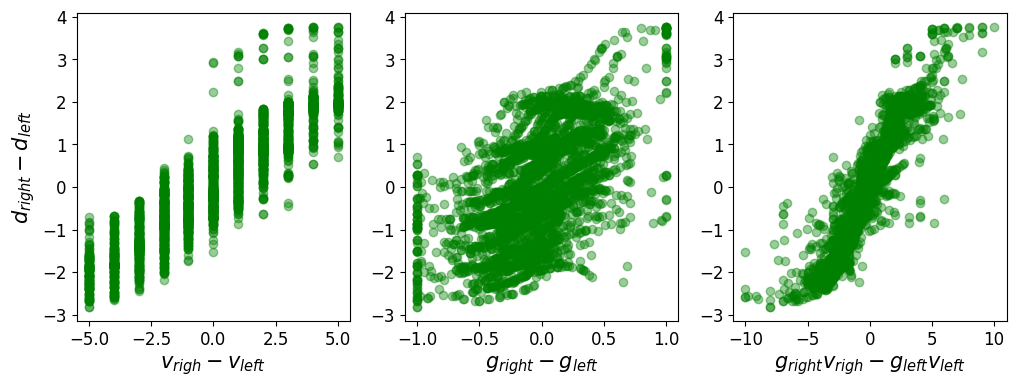

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 0] - X_test[:, 1], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.4, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');
plt.xlabel(r'$v_{righ} - v_{left}$ ');

plt.subplot(132)
plt.scatter(X_test[:, 2] - X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(133)
plt.scatter(X_test[:, 0]*X_test[:, 2] - X_test[:, 1]*X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

# plt.savefig('_plots/kr2010_complete_prmspred.pdf', 
#             dpi=600, 
#             transparent=True, 
#             bbox_inches='tight');

In [15]:
# est_gp = SymbolicRegressor(population_size=5000,
#                            function_set=['add', 'sub', 'mul', 'div'],
#                            generations=50, stopping_criteria=0.01,
#                            p_crossover=0.7, p_subtree_mutation=0.1,
#                            p_hoist_mutation=0.05, p_point_mutation=0.1,
#                            max_samples=0.9, verbose=1,
#                            parsimony_coefficient=0.01, random_state=0)
# est_gp.fit(X_train, pred_v[:, 0]-pred_v[:, 1])
# print(est_gp._program)